# Fused Softmax

Code is run and tested on my Nvidia 3090 GPU

In [2]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = driver.active.get_active_torch_device()

In [42]:
# naive softmax
def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret


# optimized version of softmax from pytorch directly
def pytorch_softmax(x):
    return torch.softmax(x, axis=1)

In [43]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, 
                   BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        row_start_ptr = input_ptr + row_idx * input_row_stride
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator

        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

    

In [44]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]

def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 8

    # Number of software pipelining stages. high level is more stages if with more SRAM
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared

    # this is to check whether number of registers and SRAM will be too much that will cause delay, might be different on different architecture
    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)

    # occupancy above is the 
    num_programs = NUM_SM * occupancy
    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    return y



### Test whether it's working

In [35]:
torch.manual_seed(0)
x = torch.randn(1893, 790, device=DEVICE)
y_triton = softmax(x)
y_torch = pytorch_softmax(x)
assert torch.allclose(y_triton, y_torch)

### Benchmark

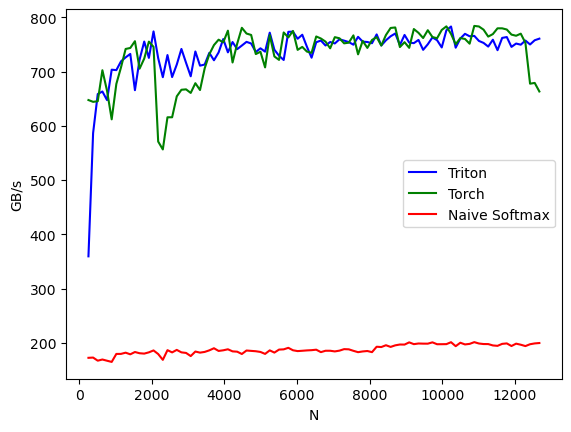

softmax-performance:
          N      Triton       Torch  Naive Softmax
0     256.0  359.587276  647.477881     172.651134
1     384.0  586.558897  644.180117     173.108943
2     512.0  658.489997  645.284035     167.388281
3     640.0  663.234527  702.442361     169.533620
4     768.0  647.397367  664.508209     167.298358
5     896.0  703.399766  611.958154     165.093093
6    1024.0  702.623353  677.155194     179.814411
7    1152.0  718.684358  707.590457     179.881034
8    1280.0  726.110203  741.588170     182.130720
9    1408.0  732.431110  743.419441     179.108729
10   1536.0  665.663099  755.892023     183.342352
11   1664.0  722.052418  705.293300     181.084735
12   1792.0  755.217935  723.853869     180.419559
13   1920.0  725.113535  755.092218     182.745650
14   2048.0  773.930177  745.530794     186.259267
15   2176.0  724.774285  571.068336     179.621858
16   2304.0  689.595869  556.497753     168.921785
17   2432.0  730.382573  615.727564     186.741144
18   2560.

In [45]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names = ['N'],
        x_vals  = [128 * i for i in range(2, 100)],
        line_arg='provider',
        line_vals=['triton', 'torch', 'naive_softmax'],
        line_names=["Triton", "Torch", "Naive Softmax"],
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))

def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    # stream = getattr(torch, DEVICE.type).Stream()
    # getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: pytorch_softmax(x))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)